# Homework 2: 
## Kamenev Vladimir

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

In [2]:
from sklearn.metrics import roc_auc_score, log_loss


In [3]:
import xlearn as xl

In [4]:
data = pd.read_csv('../../../DATA/data.csv')
data['date_time'] = data['date_time'].apply(lambda x: datetime.strptime(x.split('.')[0],'%Y-%m-%d %H:%M:%S'))# для удобной работы со временем
data = data.sort_values(by=['date_time']) 

In [5]:
print('Доступное кол-во лет: ',data['date_time'].dt.year.nunique()) ## один уникальный год
print('Доступное кол-во месяцев: ',data['date_time'].dt.month.nunique()) ## два месяца на рассмотрении
print('Доступное кол-во наблюдений по дням: ',data['date_time'].dt.date.value_counts()) ### одна дата мусор (аномалия)

Доступное кол-во лет:  1
Доступное кол-во месяцев:  2
Доступное кол-во наблюдений по дням:  2021-09-26    3102610
2021-09-29    2420588
2021-09-27    2367303
2021-09-28    2307355
2021-10-02    2128978
2021-09-30    1851189
2021-10-01    1643448
2021-09-01          1
Name: date_time, dtype: int64


### Сразу видим аномалию - 2021-09-01 (одно наблюдение, нерелевантно)

In [6]:
data = data[data['date_time'].dt.date != pd.Timestamp('2021-09-01').date()]

##### date_time - время показа рекламы
##### zone_id - id зоны, где зона - место на сайте для размещения рекламы
##### banner_id - id баннера, где баннер - сама реклама
##### campaign_clicks - общее количество показов данной кампании (которой соотвествует баннер) данному юзеру, произошедшие до текущего показа. Кампанию стоит понимать как что-то общее (рекламодатель/тематика/ и т. п.) для баннеров.
##### os_id - id операционной системы
##### country_id - id страны

##### impressions - был ли показ
##### clicks - был ли клик
##### oaid_hash - - хэш юзера

Кол-во уникальных пользователей: 6510315
Распределение кликов по дням: 


'Как выглядят данные '

,zone_id,banner_id,campaign_clicks,os_id,country_id,oaid_hash,clicks
5041415,41,29,1,3,0,1834033519797437404,0
1442602,1,188,2,2,15,7416450538971744701,0
7232498,17,52,2,2,5,1832228443297591417,0
14938691,47,73,1,4,13,4180077124914749282,0
11536774,48,266,1,0,1,1459689388363839798,0


'Описание фичей и переменной'

,zone_id,banner_id,campaign_clicks,os_id,country_id,oaid_hash,clicks
count,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07
mean,8.152680e+01,3.816483e+02,6.238540e-01,1.840605e+00,4.346986e+00,4.610505e+18,2.668835e-02
std,1.632448e+02,3.959386e+02,9.249152e+00,1.530005e+00,4.317701e+00,2.663858e+18,1.611710e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.116911e+12,0.000000e+00
25%,1.400000e+01,5.200000e+01,0.000000e+00,1.000000e+00,0.000000e+00,2.297977e+18,0.000000e+00
50%,1.900000e+01,2.170000e+02,0.000000e+00,2.000000e+00,4.000000e+00,4.614236e+18,0.000000e+00
75%,6.000000e+01,6.110000e+02,0.000000e+00,3.000000e+00,7.000000e+00,6.914243e+18,0.000000e+00
max,3.443000e+03,1.632000e+03,8.290000e+02,1.000000e+01,1.600000e+01,9.223371e+18,1.000000e+00


'Количество уникальных значений'

zone_id               3444
banner_id             1633
campaign_clicks        822
os_id                   11
country_id              17
oaid_hash          6510315
clicks                   2
dtype: int64

По описанию все фичи являются категориальными, кроме campaign_clicks (время пока не трогаем)
Распределение кликов по признакам:


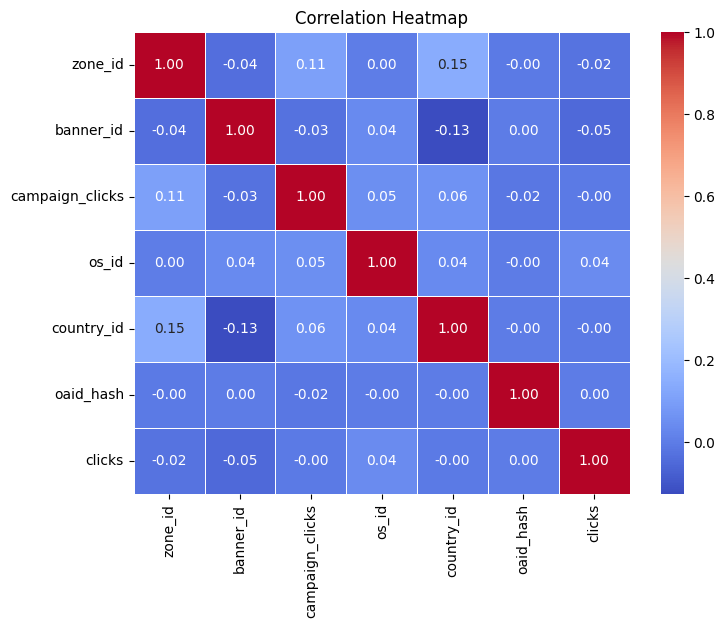

Отсуствует сильная корреляция между признаками, нет необходимости отбрасывать признаки (для построения устойчивого решения
Гистограммы распределения признаков от таргета


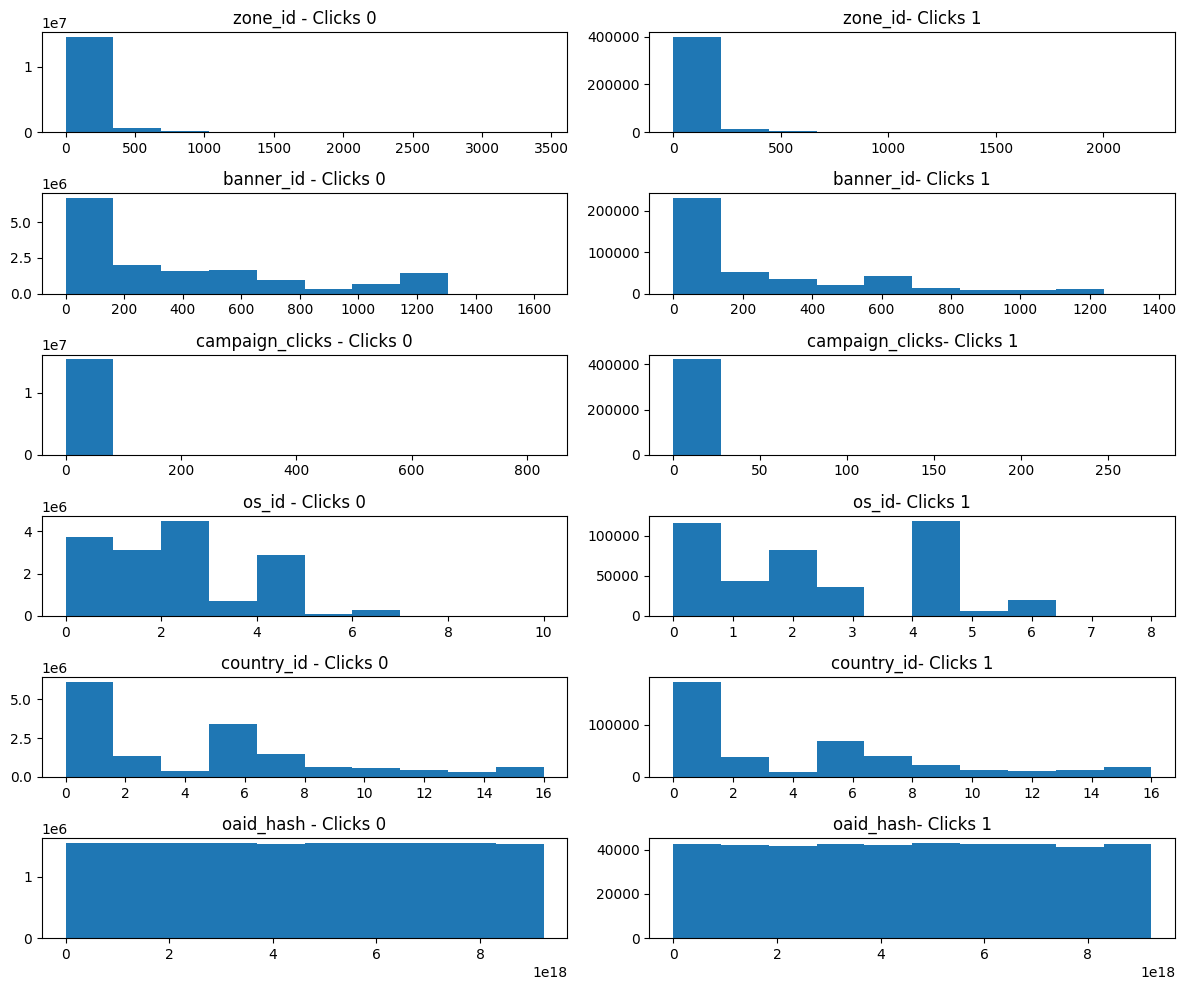

In [7]:
def analysis(data: pd.DataFrame):
    feats = ['zone_id','banner_id','campaign_clicks','os_id',
             'country_id','oaid_hash'] ### у Impressions одно уникальное значение, поэтому дроп
    target = 'clicks'
    exploration_data  =pd.concat([data[feats],data[target]],axis=1)
    unique_users = data['oaid_hash'].nunique()
    print(f'Кол-во уникальных пользователей: {unique_users}')
    print('Распределение кликов по дням: ')
    
    display('Как выглядят данные ', exploration_data.head())
    display('Описание фичей и переменной',exploration_data.describe())
    display('Количество уникальных значений', exploration_data.nunique())
    print('По описанию все фичи являются категориальными, кроме campaign_clicks (время пока не трогаем)')
    print('Распределение кликов по признакам:')
    df_corr = exploration_data.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Heatmap')
    plt.show()
    print('Отсуствует сильная корреляция между признаками, нет необходимости отбрасывать признаки (для построения устойчивого решения')
    print('Гистограммы распределения признаков от таргета')
    fig, axs = plt.subplots(len(feats), 2, figsize=(12, 10))
    for i,feat in enumerate(feats):
        axs[i][0].hist(exploration_data[exploration_data[target]==0][feat])
        axs[i][1].hist(exploration_data[exploration_data[target]==1][feat])
        axs[i][0].set_title(f'{feat} - Clicks 0')
        axs[i][1].set_title(f'{feat}- Clicks 1')
    fig.tight_layout()
    plt.show()
    
analysis(data)

In [8]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    encoder = LabelEncoder()
    # Выбрасываем мусор и прочее
    data = data.drop_duplicates()
    data = data.drop(columns=['impressions'],axis=1)
    data = data.drop(columns=[ 'banner_id0', 'banner_id1',
                          'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1'],
                 axis=1)# Не нужны для первого дз
    data['month'] = data['date_time'].dt.month
    data['day'] = data['date_time'].dt.day
    data['hour'] = data['date_time'].dt.hour
    data['minute'] = data['date_time'].dt.minute
    data['second'] = data['date_time'].dt.second
    data['campaign_ad'] = data['campaign_clicks'].apply(lambda x: int(bool(x))) # были ли показы от от данной компании
    data['is_day'] = data['hour'].apply(lambda x: 1 if int(x)>=12 and int(x) <=24 else 0) # Был ли показ днем
    data['is_night'] = data['is_day'].apply(lambda x: 1 if x==0 else 0) # Был ли показ ночью
    data['is_weekend'] = data['date_time'].apply(lambda x: 1 if x.weekday() > 4 else 0) # Был ли показ на выходных
    return data
data = feature_engineering(data)

##### Выделим фичи для преобразования + сырые (их не трогаем)

In [9]:
feats = ['zone_id','banner_id','campaign_clicks','os_id','country_id','month','day','hour','campaign_ad',
        'is_day','is_night','is_weekend','oaid_hash']
feats_to_trans = ["zone_id", "banner_id", "oaid_hash" ,"os_id", "country_id", 'month','day','hour','oaid_hash']
raw_feats = ['campaign_clicks']
target = 'clicks'


In [10]:
raw_feats

['campaign_clicks']

##### Последний день для теста, для обучения и валидации пользуемся train_test_split

In [11]:
end_last_day = data['date_time'].iloc[-1]
start_last_day = end_last_day - pd.to_timedelta(1, unit='d')

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
train,val = train_test_split(data[(data['date_time']<start_last_day)],shuffle=True)

In [14]:
test = data[(data['date_time']>start_last_day) & (data['date_time']<=end_last_day)]

In [15]:
# train = train.sample(frac=0.001) ### Для проверки работоспособности, в демо не используется
# test = test.sample(frac=0.001)
# val = val.sample(frac=0.001)

##### FFM - модель из xlearn работает с данными формата libffm

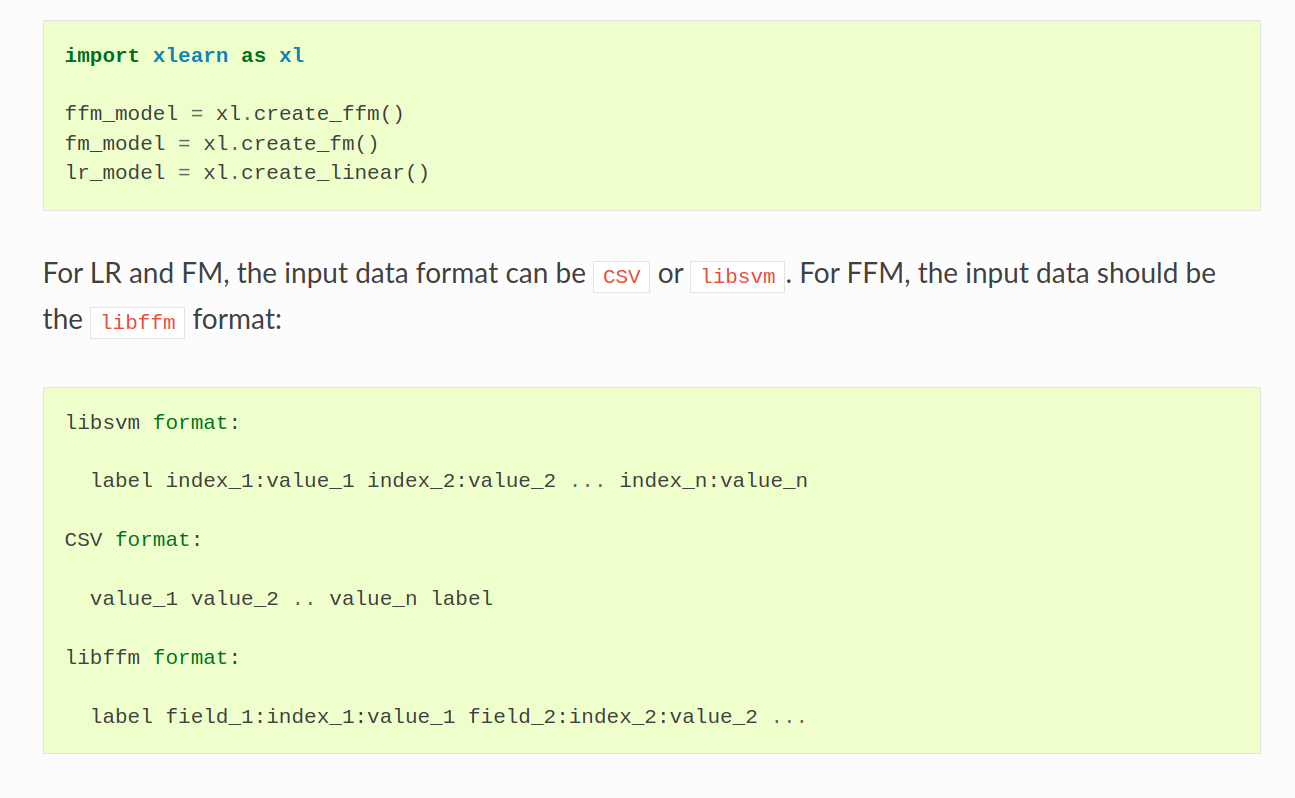

##### Берем готовую реализацию

In [16]:
from utils import *

In [17]:
encoder = {"currentcode": len(raw_feats),
           "catdict": {},
           "catcodes": {}}

In [18]:
encoder = convert_to_ffm('', train, 'train', target,
                          raw_feats,
                          feats_to_trans,
                          feats,
                          encoder)

convert_to_ffm - START
UPDATING CATDICT: numeric field - campaign_clicks
UPDATING CATDICT: categorical field - zone_id
UPDATING CATDICT: categorical field - banner_id
UPDATING CATDICT: categorical field - oaid_hash
UPDATING CATDICT: categorical field - os_id
UPDATING CATDICT: categorical field - country_id
UPDATING CATDICT: categorical field - month
UPDATING CATDICT: categorical field - day
UPDATING CATDICT: categorical field - hour


In [19]:
encoder = convert_to_ffm('', val, 'val', target,
                          raw_feats,
                          feats_to_trans,
                          feats,
                          encoder)


convert_to_ffm - START


In [20]:
encoder = convert_to_ffm('', test, 'test', target,
                          raw_feats,
                          feats_to_trans,
                          feats,
                          encoder)

convert_to_ffm - START


##### Подберем лучшие гиперпараметры на сетке

In [21]:
y_test = test['clicks']
y_val = val['clicks']

In [22]:
best_logloss=  np.inf
best_roc_auc = 0.5
best_param_k = 0
best_param_lr = 0

In [23]:
del train,val,test,data

In [24]:
size_lat_factor = np.arange(3,7)
for k in size_lat_factor:
    for lr in [0.1,0.2]:
        ffm_model = xl.create_ffm()
        ffm_model.setTrain("train_ffm.txt")
        ffm_model.setTest("val_ffm.txt")
        ffm_model.fit(param = {'task':'binary', 'lr': lr, 'lambda': 0.001, 'k': k, 'metric': 'auc'},
                      model_path = './model.out')
        ffm_model.setSigmoid()
        ffm_model.predict('./model.out', './output.txt')

        with open('output.txt', 'r') as f:
            y_pred_proba = np.array(list(map(float, filter(lambda s: len(s) > 0, f.read().split('\n'))))) 
        ### Посчитаем log_loss и roc_auc_score
        cur_roc_auc = roc_auc_score(y_val, y_pred_proba)
        cur_log_loss= log_loss(y_val, y_pred_proba)
        if cur_log_loss<best_logloss:
            best_logloss = cur_log_loss
            best_param_k = k
            best_param_lr = lr
        del ffm_model


----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[ WARNING    ] Validation file not found, xLearn has already disable early-stopping.
[ WARNING    ] Validation file not found, xLearn has already disable (-x auc) option.
[------------] xLearn uses 16 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train_ffm.txt.bin) NOT found. Convert text file to binary file.
[------------] Number of Feature: 4692459
[------------] Number of Field: 9
[------------] Time cost for reading problem: 12.93 (sec)
[ ACTION    

In [25]:
print(f'Best params:\n  k: {best_param_k} \n lr: {best_param_lr}')

Best params:
  k: 6 
 lr: 0.2


### Итоговая модель:

In [27]:
ffm_model = xl.create_ffm()
ffm_model.setTrain("train_ffm.txt")
ffm_model.setTest("test_ffm.txt")
param = {'task':'binary', 'lr': best_param_lr, 'lambda': 0.001, 'k': best_param_k, 'metric': 'auc'}

ffm_model.fit(param, './model.out')
ffm_model.setSigmoid()
ffm_model.predict('./model.out', './output.txt')

with open('output.txt', 'r') as f:
    y_proba = np.array(list(map(float, filter(lambda s: len(s) > 0, f.read().split('\n')))))
cur_roc_auc = roc_auc_score(y_test, y_proba)
cur_log_loss = log_loss(y_test, y_proba)
print(f'roc_auc_score : {cur_roc_auc}, log_loss : {cur_log_loss}')

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[ WARNING    ] Validation file not found, xLearn has already disable early-stopping.
[ WARNING    ] Validation file not found, xLearn has already disable (-x auc) option.
[------------] xLearn uses 16 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train_ffm.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 4692459
[------------] Number of Field: 9
[------------] Time cost for reading problem: 3.79 (sec)
[ ACTION     ] Init

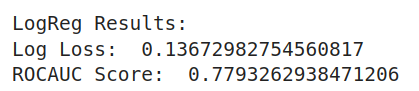

Таким образом, текущая модель превосходит мою модель из первой дз